In [1]:
# make imports work
import sys
sys.path.insert(0, "/Users/JonathanHeitz/git/dementia/src/")

import matplotlib.pyplot as plt
import os
import json
import shap
import numpy as np
import pandas as pd
from collections import defaultdict
from IPython.display import Image, display
from config.config import Config
from dataloader.dataset import Dataset


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data collection
First, let's load the results from the result directories, and bring them in a form we can analyse more easily

In [2]:

base_dir = '/Volumes/methlab/Students/Jonathan/results/runs'
results_base_dir = ["2023_kw38/20230922_1935_0ece_overview",
                    "2023_kw38/20230922_1935_52e5_overview",
                    "2023_kw38/20230922_1935_ad17_overview"]
results_dirs = [os.path.join(base_dir, base) for base in results_base_dir if os.path.exists(os.path.join(base_dir, base, "metrics.txt"))] +\
               [os.path.join(base_dir, base, dir) for base in results_base_dir for _, dirs, _ in os.walk(os.path.join(base_dir, base)) for dir in dirs if os.path.exists(os.path.join(base_dir, base, dir, "metrics.txt"))]

labels = defaultdict(lambda: [])
predictions = defaultdict(lambda: [])
shap_values = defaultdict(lambda: [])
dirs = defaultdict(lambda: [])
test_data = defaultdict(lambda: [])
for d in results_dirs:
    basename = os.path.basename(d)
    yaml_file = [f for f in os.listdir(d) if f.endswith(".yaml")][0]
    config = Config.from_yaml(os.path.join(d, yaml_file))

    try:
        preprocessors = str([path.preprocessors for path in config.pipeline]).replace("[['Audio Features'], ['Linguistic Features']]", "AudioF+LinguF")
        print(preprocessors)
    except:
        preprocessors = "+".join(config.preprocessors).replace("Linguistic Features Literature", "LinguFL").replace("Other Model Prediction", "BERT").replace("Automatic Punctuation", "Punct").replace("Audio Features", "AudioF")
        preprocessors = preprocessors.replace("ASR google_speech", "Google").replace("ASR wave2vec2", "w2v").replace("ASR whisper", "Whisper").replace("PAR segmentation", "cut")

    #data_params = f"par{int(config.config_data['only_PAR'])},pause{int(config.config_data['keep_pauses'])},term{int(config.config_data['keep_terminators'])},unint{int(config.config_data['keep_unintelligable_speech'])}"
    try:
        data = config.data
    except:
        data = str([path.data for path in config.pipeline])
    data = data.replace("ADReSS_audio", "ADR").replace("ADReSS_with_PITT_audio", "ADR_PITT").replace("ADReSS_manual_transcripts", "manual")
    model = config.model.replace("RandomForest", "RF").replace("GradientBoosting", "GB").replace("BERT_NEW","BERT")

    try:
        chat_parser_version = config.chat_parser_version
    except:
        chat_parser_version = "default"

    try:
        inv_par = config.config_data.only_PAR == False
    except:
        inv_par = False

    if inv_par:
        print("Skipping", d)
        continue

    if 'cut' not in preprocessors and 'manual' not in data:
        print("Skipping", d)
        continue

    if model == 'BERT':
        continue


    parameter_string = f"{data} {preprocessors} {model}"# {run_version}"#({data_params})"

    parameter_string_mapping = {
        'ADR cut+w2v BERT': 'Wave2vec2 BERT',
        'ADR cut+Google BERT': 'GoogleSpeech BERT',
        'ADR cut+Whisper+LinguFL RF': 'Whisper Linguistic',
        'ADR cut+Whisper BERT': 'Whisper BERT',
        'ADR cut+w2v+LinguFL RF': 'Wave2vec2 Linguistic',
        'ADR cut+Google+LinguFL RF': 'GoogleSpeech Linguistic',
        'manual  BERT': 'Manual BERT',
        'manual LinguFL RF': "Manual Linguistic"
    }
    parameter_string = parameter_string_mapping.get(parameter_string, parameter_string)

    dirs[parameter_string].append(d)

    #print(dataset, lr_schedule, d)
    with open(os.path.join(d, "predictions.txt"), "r") as f:
        data = json.load(f)
        flat = [item for items in data for item in items]
        predictions[parameter_string].append(flat)
    with open(os.path.join(d, "labels.txt"), "r") as f:
        data = json.load(f)
        flat = [item for items in data for item in items]
        labels[parameter_string].append(flat)

    shap_values_here = np.load(os.path.join(d,"shap_values.npy"))
    with open(os.path.join(d, "feature_correlation.txt"), "r") as f:
        data = json.load(f)
        features_names = list(data.keys())

    shap_values_here_df = pd.DataFrame(shap_values_here, columns=features_names)
    shap_values[parameter_string].append(shap_values_here_df)
    test_data[parameter_string].append(Dataset.from_disk(os.path.join(d, "dataset")).data)


print(*[f"{parameter_string}: {len(predictions[parameter_string])} results" for parameter_string in predictions], sep="\n")

Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_1008_BERT_on_wave2vec2_wdcm
Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_1325_BERT_on_manual_INV_PAR_ogpf
Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_1430_BERT_on_wave2vec2_szli
Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_0903_BERT_on_manual_INV_PAR_xpnf
Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_0726_ling_feat_lit_google_speech_qpuk
Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_0847_linguistic_features_literature_INV_PAR_esec
Skipping /Volumes/methlab/Students/Jonathan/results/runs/2023_kw38/20230922_1935_0ece_overview/20230924_1746_BERT_on_manual_INV_PAR_duxs
Skipping /Volumes/methlab/Stud

## Feature importance analysis

We calculate feature importance for each parameter_string and plot the SHAP values

Whisper Linguistic


,0_x,0_y,0
honores_statistic,0.045136,0.046707,0.048531
noun_ratio,0.035105,0.034174,0.033924
adverb_ratio,0.033903,0.033462,0.033452
pronoun_noun_ratio,0.028048,0.027668,0.027797
avg_word_length,0.025959,0.026744,0.026538
NP -> DT_NN,0.022804,0.022481,0.023415
PRP_ratio,0.021902,0.021750,0.020615
n_words,0.021306,0.021716,0.020233
personal_pronoun_ratio,0.018036,0.018387,0.017428
n_unique_words,0.017322,0.017953,0.018187


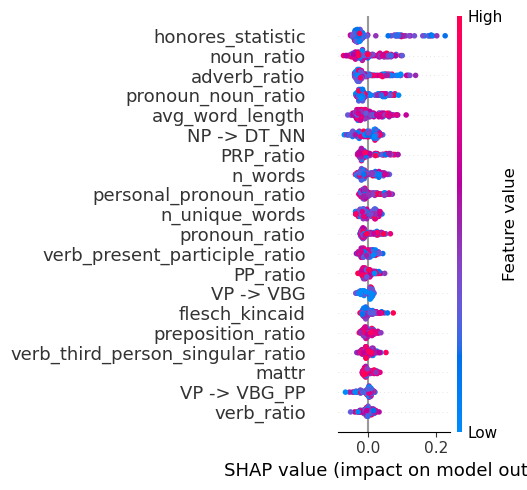

Wave2vec2 Linguistic


,0_x,0_y,0
avg_word_length,0.052436,0.050678,0.051361
PRP_ratio,0.037977,0.039029,0.038600
VP -> VBG_PP,0.036423,0.035317,0.036275
noun_ratio,0.027871,0.028719,0.028218
personal_pronoun_ratio,0.024168,0.024390,0.024022
flesch_kincaid,0.023402,0.023235,0.025641
verb_present_participle_ratio,0.023389,0.023226,0.022462
NP -> DT_NN,0.022753,0.023678,0.024193
n_unique_words,0.019956,0.020866,0.020731
avg_sentence_length,0.019567,0.019020,0.019291


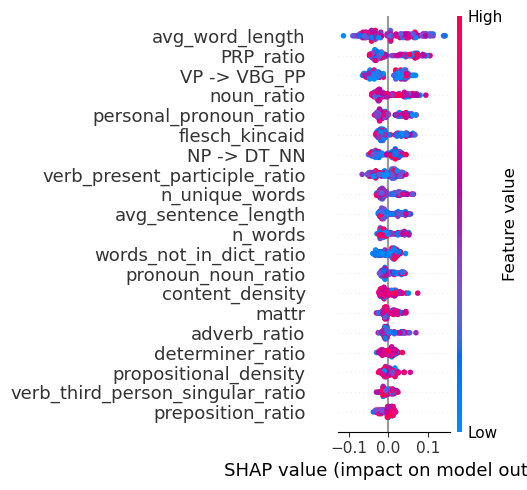

GoogleSpeech Linguistic


,0_x,0_y,0
pronoun_noun_ratio,0.042111,0.042501,0.041991
adverb_ratio,0.041773,0.043487,0.043550
noun_ratio,0.041331,0.040700,0.042330
NP -> DT_NN,0.036225,0.037289,0.035863
honores_statistic,0.022070,0.022699,0.021833
n_unique_words,0.021010,0.022251,0.020444
pronoun_ratio,0.020773,0.020383,0.019635
verb_present_participle_ratio,0.019863,0.018149,0.018312
flesch_kincaid,0.019180,0.019374,0.018401
VP -> VBG,0.018164,0.017255,0.017353


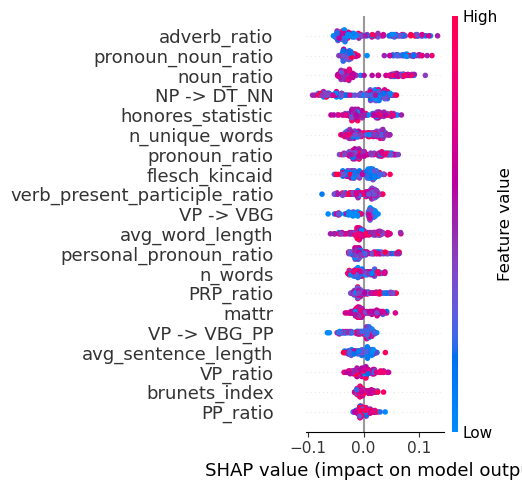

Manual Linguistic


,0_x,0_y,0
avg_word_length,0.047559,0.046081,0.047188
adverb_ratio,0.034250,0.033957,0.036065
PRP_ratio,0.030239,0.030406,0.030486
honores_statistic,0.027897,0.026839,0.027675
flesch_kincaid,0.027875,0.028725,0.028350
personal_pronoun_ratio,0.025411,0.026905,0.027520
NP -> DT_NN,0.024384,0.024149,0.024068
pronoun_noun_ratio,0.023173,0.022863,0.022001
pronoun_ratio,0.021202,0.019984,0.021049
n_unique_words,0.018984,0.019057,0.019944


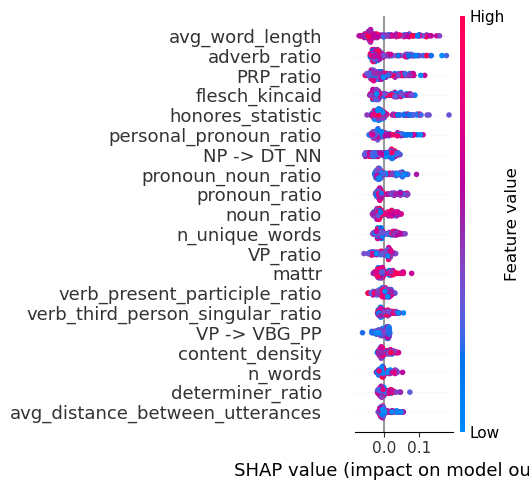

In [3]:
feature_importance = {}

for parameter_string in shap_values:
#for parameter_string in ['Wave2vec2 Linguistic']:
    print(parameter_string)

    # test data should be the same everywhere
    assert all([td.equals(test_data[parameter_string][0]) for td in test_data[parameter_string]])
    test_data_here = test_data[parameter_string][0]

    shap_values_concatenated = pd.concat(shap_values[parameter_string])
    shap_data_over_multiple_runs = shap_values_concatenated.groupby(level=0).mean()

    feature_importance_all_runs = []
    for shap_values_here in shap_values[parameter_string]:
        #shap.summary_plot(shap_values_example, test_data_here, plot_size=(5,5))
        feature_importance_all_runs.append(pd.DataFrame(shap_values_here, columns = test_data_here.columns).abs().mean(axis=0).sort_values(ascending=False,))
    feature_importance_all_runs_merged = pd.DataFrame(feature_importance_all_runs[0])
    for i in range(1,len(feature_importance_all_runs)):
        feature_importance_all_runs_merged = feature_importance_all_runs_merged.merge(pd.DataFrame(feature_importance_all_runs[i]), left_index=True, right_index=True)
    display(feature_importance_all_runs_merged)

    shap.summary_plot(shap_data_over_multiple_runs.values, test_data_here, plot_size=(5,5))

    feature_imp1 = shap_data_over_multiple_runs.abs().mean(axis=0).sort_values(ascending=False,)
    feature_importance[parameter_string] = feature_imp1
    #display(feature_imp1)

    #break


In [4]:


# We just take one result per setting, as they are all very similar

In [85]:
for parameter_string in shap_values:
    print(parameter_string)

    # test data should be the same everywhere
    assert all([td.equals(test_data[parameter_string][0]) for td in test_data[parameter_string]])
    test_data_here = test_data[parameter_string][0]

    # take only first run, they are all almost identical
    shap_values_here = shap_values[parameter_string][0]

    feature_imp = pd.DataFrame(shap_values_here, columns=test_data_here.columns).abs().mean(axis=0).sort_values(ascending=False,)
    feature_importance[parameter_string] = pd.DataFrame(feature_imp, columns=[parameter_string])
    #display(feature_importance[parameter_string])

combined = feature_importance['Manual Linguistic']
for parameter_string in feature_importance:
    if parameter_string == 'Manual Linguistic':
        continue
    combined = combined.merge(feature_importance[parameter_string], left_index=True, right_index=True)

combined = combined[['Whisper Linguistic', 'GoogleSpeech Linguistic', 'Wave2vec2 Linguistic',  'Manual Linguistic']]
combined

Whisper Linguistic
Wave2vec2 Linguistic
GoogleSpeech Linguistic
Manual Linguistic


,Whisper Linguistic,GoogleSpeech Linguistic,Wave2vec2 Linguistic,Manual Linguistic
avg_word_length,0.025959,0.016636,0.052436,0.047559
adverb_ratio,0.033903,0.041773,0.010732,0.034250
PRP_ratio,0.021902,0.013947,0.037977,0.030239
honores_statistic,0.045136,0.022070,0.006207,0.027897
flesch_kincaid,0.011017,0.019180,0.023402,0.027875
personal_pronoun_ratio,0.018036,0.016430,0.024168,0.025411
NP -> DT_NN,0.022804,0.036225,0.022753,0.024384
pronoun_noun_ratio,0.028048,0.042111,0.014273,0.023173
pronoun_ratio,0.016939,0.020773,0.004132,0.021202
n_unique_words,0.017322,0.021010,0.019956,0.018984


# Combine into plot and store results to disk
The results will be used by linguistic_features-manual_vs_asr.py

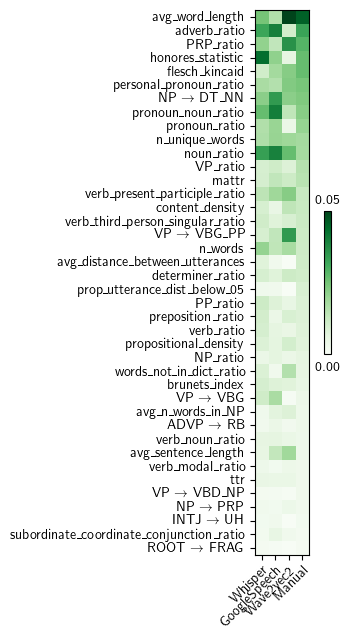

In [95]:
with plt.rc_context({"text.usetex": True, "font.family": "sans-serif", "font.size": 10, "lines.linewidth": 0.5}):
    fig, ax = plt.subplots(1, 1, figsize=(4,6.5) )
    c = ax.imshow(combined.values, cmap='Greens')#, cmap='RdBu', vmin=-np.max(combined.values), vmax=np.max(combined.values))
    ax.set_yticks(range(len(combined.index)), [feature_name.replace("->", r"$\rightarrow$") for feature_name in combined.index])
    ax.set_xticks(range(len(combined.columns)), [c.replace(" Linguistic","") for c in combined.columns], rotation=45, ha='right', rotation_mode='anchor')
    cbar = fig.colorbar(c, ax=ax, fraction=0.02, pad=0.04, ticks=[])
    cbar.ax.text(0.5, -0.05, f"{cbar.vmin:.2f}", transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.03, f"{cbar.vmax:.2f}", transform=cbar.ax.transAxes, va='bottom', ha='center')

    #cbar.set_label('Mean absolute SHAP value')

    plt.tight_layout()
    
    #plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig("plots/feature_importance.pdf")
    plt.show()

In [24]:
# store to disk so it can be included in the other plot
import pickle
with open("feature_importance_overview.pkl", "wb") as f:
    pickle.dump(combined, f)